# Imports

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms

%matplotlib inline

# Data processing

In [2]:
# Normalization mean and standard deviation used to train PyTorch pretrained models.
_mean = torch.tensor([0.485, 0.456, 0.406])
_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, size=192, device='cpu'):
    
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=_mean, std=_std),
        transforms.Lambda(lambda x: x.unsqueeze(0).to(device)),
    ])
    
    return transform(img)
    
def postprocess(x):
    
    transform = transforms.Compose([
        transforms.Lambda(lambda x: x.to('cpu').squeeze(0)),
        transforms.Normalize(mean=[0,0,0], std=[1.0/s for s in _std]),
        transforms.Normalize(mean=[-m for m in _mean], std=[1.,1.,1.]),
        transforms.Lambda(rescale),
        transforms.ToPILImage(),
    ])
    
    return transform(x)

def rescale(x):
    
    lo, hi = x.min(), x.max()
    return (x - lo) / (hi - lo)

# Load a pretrained model for feature extraction.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load a pretrained SqueezeNet model. Set requires_grad = False for its parameters since
# we do not want to train the model.
model = models.squeezenet1_1(pretrained=True).features.to(device).eval()
for param in model.parameters():
    param.requires_grad = False
    
def extract_features(x, model):
    
    features = []
    cur_feature = x.clone()
    for module in model._modules.values():
        cur_feature = module(cur_feature)
        features.append(cur_feature)
        
    return features

/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


# Loss functions.

In [4]:
def tv_loss(img, tv_weight):
    """Computes total-variation loss for an image.
    """
    
    _, _, H, W = img.shape
    term1 = img[:, :, 1:, :] - img[:, :, :H-1, :]
    term2 = img[:, :, :, 1:] - img[:, :, :, :W-1]
    loss = tv_weight * (torch.norm(term1)**2 + torch.norm(term2)**2)
    
    return loss

def content_loss(features, content_features, content_weight):
    """Computes loss between content image features and computed features.
    """
    
    return content_weight * torch.norm(features - content_features)**2

def gram_matrix(features, normalize=True):
    """Computes the Gram matrix for the given features and
    (optionally) normalizes it.
    """
    
    N, C, H, W = features.shape
    feats = features.view(N*C, H*W)
    gram = torch.mm(feats, feats.t())
    if normalize:
        gram /= (C*H*W)
        
    return gram

def style_loss(features, style_features, style_weights, style_indices):
    """Computes the loss between the style image features and and computed features.
    """
    
    loss = 0.0
    for (i, idx) in enumerate(style_indices):
        gram = gram_matrix(features[idx], normalize=True)
        loss += style_weights[i] * torch.norm(gram - style_features[i])**2
        
    return loss

# Style transfer!

In [37]:
def style_transfer(content_image, style_image,
                   content_idx, style_indices,
                   content_weight, style_weights, tv_weight):
    
    # Extract features for the content image.
    content_img = preprocess(Image.open(content_image))
    content_features = extract_features(content_img, model)[content_idx].clone()
    
    # Extract features for the style image.
    style_img = preprocess(Image.open(style_image))
    _style_features = extract_features(style_img, model)
    style_features = [gram_matrix(_style_features[i].clone()) for i in style_indices]
    
    # Initialize image variable.
    img = content_img.clone()
    img.requires_grad_()
    
    print('Initial image')
    plt.imshow(postprocess(img.detach()))
    plt.show()
    
    print('Style image')
    plt.imshow(postprocess(style_img.detach()))
    plt.show()
    
    iterations = 200
    initial_lr = 3.0
    
    optimizer = optim.Adam([img], lr=initial_lr)
    
    for t in range(iterations):
        
        optimizer.zero_grad()
        features = extract_features(img, model)
        loss = content_loss(features[content_idx], content_features, content_weight) \
             + style_loss(features, style_features, style_weights, style_indices) \
             + tv_loss(img, tv_weight)
        loss.backward()
        optimizer.step()
        
        img.data.clamp_(-1.5, 1.5)
        
        if t % 50 == 0:
            print('Iteration {}'.format(t))
            plt.imshow(postprocess(img.detach()))
            plt.show()
        
    plt.imshow(postprocess(img.detach()))
    plt.show()
        


Initial image


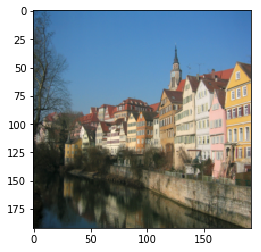

Style image


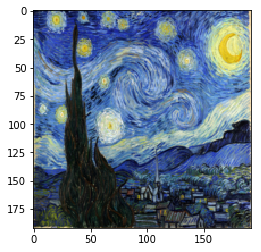

Iteration 0


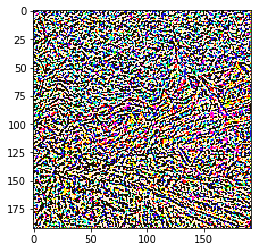

Iteration 50


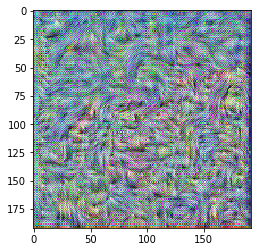

Iteration 100


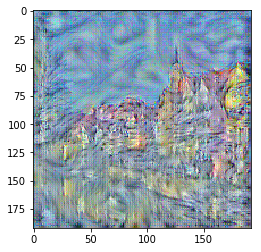

Iteration 150


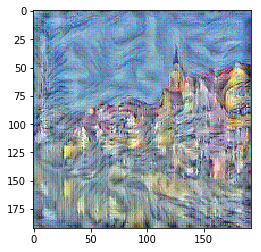

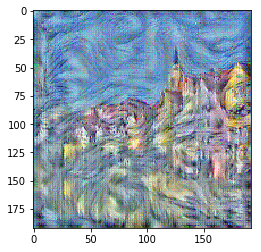

In [38]:
# vgg_content_idx       = 7
# vgg_style_indices     = [0, 2, 5, 7, 10]
squeeze_content_idx   = 3
squeeze_style_indices = [1, 4, 6, 7]

params = {
    'content_image'  : 'styles/tubingen.jpg',
    'style_image'    : 'styles/starry_night.jpg',
    'content_idx'    : squeeze_content_idx,
    'style_indices'  : squeeze_style_indices,
    'content_weight' : 5e-2,
    'style_weights'  : [10000, 5000, 15, 3],
    'tv_weight'      : 2e-2,
}

style_transfer(**params)